# Kaggle: Forest Cover Type Prediction

Kaggle Problem: [Forest Cover Type Prediction](https://www.kaggle.com/c/forest-cover-type-prediction/overview)

Objective: predict the forest cover type in regions of Roosevelt National Forest using cartographic data

Evaluation metric: accuracy of classification

Modeling methods: ExtraTreesClassifier with tuned hyperparameters

Results:
- For my model, the most important features for classification were: elevation, soil type, and wilderness area.
- The highest accuracy was obtained in classifying forest cover types of cottonwood/willow, aspen, and krummholz trees.
- The most difficult forest cover types to correctly distinguish were those of spruce/fir and lodgepole pine trees.
- A classification accuracy score of 0.80522 was achieved for the test data set (corresponding to top 10% on the Kaggle leaderboard).

# Organization:

1. [The data](#'section_1') 
    1. [Reading in training and test data](#section_1.1)  
    + [Numerical and categorical features](#section_1.2) 

+ [Data cleaning](#section_2)
    1. [Changing the default encoding of nominal features](#section_2.1) 
    + [Missing data](#section_2.2) 

+ [Exploratory data analysis](#section3) 
    1. [Distribution of the target variable](#section_3.1)  
    + [Analysis of features](#section_3.2)     
    + [Correlation analysis](#section_3.3)
        1. [Feature - Target Correlation](#section_3.3.1)  
        + [Feature - Feature Correlation](#section_3.3.2)        
        
+ [Feature engineering](#section4)
    1. [Total distance to hydrology](#section_4.1)   
    + [Total shade](#section_4.2)  
    + [Feature interaction terms](#section_4.3)   
    + [Summary of new created features](#section_4.4)    
    
+ [Data pre-processing](#section_5)
    1. [Assessing the encoding of nominal features](#section_5.1)   
    + [Skewed features and log transforms](#section_5.2)  
    + [sklearn Pipeline for pre-processing](#section_5.3)  
    + [Final prepping of the data before modeling](#section_5.4)  
    
+ [Modeling with ExtraTreesClassifier](#section_6)
    1. [Feature selection](#section_6.1)   
    + [Fitting the model](#section_6.2)   
    + [Making predictions on the test set](#section_6.3)  

+ [Results of modeling](#section_7)
    1. [Feature importances](#section_7.1)   
    + [Distribution of predicted classes](#section_7.2)   
    + [Accuracy of model classification](#section_7.3)  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1. The Data <a id='section_1'></a>
- [1.1 Reading in training and test data](#section_1.1)  
- [1.2 Numerical and categorical features](#section_1.2)   

## 1.1 Reading in training and test data <a id='section_1.1'></a>


In [2]:
# Read in the training and test data sets
X = pd.read_csv('./input/train.csv', index_col='Id')  # training data
X_test = pd.read_csv('./input/test.csv', index_col='Id')  # test data

# Remove any rows from the training set where there is no target
X.dropna(axis=0, subset=['Cover_Type'], inplace=True)

# Separate out the target in the training set
y = X['Cover_Type'] # target
#X.drop('Cover_Type', axis=1, inplace=True)

# Names of target classes
class_names = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 
               'Aspen', 'Douglas-fir', 'Krummholz']
#1 - Spruce/Fir
#2 - Lodgepole Pine
#3 - Ponderosa Pine
#4 - Cottonwood/Willow
#5 - Aspen
#6 - Douglas-fir
#7 - Krummholz

In [3]:
X.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
Id,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
2,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
3,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
4,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
5,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [4]:
X.shape

(15120, 55)

In [5]:
# Combining train and test data sets
X_all = pd.concat([X, X_test], axis=0, sort=False)

## 1.2 Numerical and categorical features <a id='section_1.2'></a>

In [6]:
X_all.dtypes

Elevation                               int64
Aspect                                  int64
Slope                                   int64
Horizontal_Distance_To_Hydrology        int64
Vertical_Distance_To_Hydrology          int64
Horizontal_Distance_To_Roadways         int64
Hillshade_9am                           int64
Hillshade_Noon                          int64
Hillshade_3pm                           int64
Horizontal_Distance_To_Fire_Points      int64
Wilderness_Area1                        int64
Wilderness_Area2                        int64
Wilderness_Area3                        int64
Wilderness_Area4                        int64
Soil_Type1                              int64
Soil_Type2                              int64
Soil_Type3                              int64
Soil_Type4                              int64
Soil_Type5                              int64
Soil_Type6                              int64
Soil_Type7                              int64
Soil_Type8                        

All data features have numerical values, but 'Wilderness_Area\*' and 'Soil_Type\*' columns are actually one-hot encoded nominal features.

In [7]:
# Categorical (nominal) features
catnom_cols = list(X.filter(regex='^Wilderness',axis=1).columns)+list(X.filter(regex='^Soil',axis=1).columns)

# Numerical features
num_cols = list(set(X.columns)-set(catnom_cols)-set(['Cover_Type']))

print('Numerical features:\n', num_cols)
print()
print('Categorical features:\n', catnom_cols)

Numerical features:
 ['Slope', 'Horizontal_Distance_To_Roadways', 'Hillshade_3pm', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Hydrology', 'Elevation', 'Hillshade_9am', 'Hillshade_Noon', 'Aspect']

Categorical features:
 ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']


# 2. Data Cleaning <a id='section_2'></a>

- [2.1 Changing the default encoding of nominal features](#section_2.1) 
- [2.2 Missing data](#section_2.2)   

## 2.1 Changing the default encoding of nominal features <a id='section_2.1'></a>

In the provided data sets, 'Wilderness_Area\*' and 'Soil_Type\*' columns are one-hot encoded nominal features. For the purpose of understanding these features better, I'll collapse them into single columns with ordinal encoding. I'll decide later on what kind of encoding to use on these features for modeling. 

In [8]:
# Check that observations are designated as a singular Wilderness_Area or Soil_Type
set(X_all.filter(regex='^Wilderness_',axis=1).sum(axis=1)), set(X_all.filter(regex='^Soil_',axis=1).sum(axis=1))

({1}, {1})

In [9]:
# Combining Wilderness_Area* and Soil_Type* columns 

X_all['WildernessArea'] = np.zeros(len(X_all))
for col in X_all.filter(regex='^Wilderness_',axis=1).columns:
    ind_label = X_all[X_all[col]==1].index
    X_all.loc[ind_label,'WildernessArea'] = col.split('Wilderness_Area')[1]
    
X_all['SoilType'] = np.zeros(len(X_all))
for col in X_all.filter(regex='^Soil_',axis=1).columns:
    ind_label = X_all[X_all[col]==1].index
    X_all.loc[ind_label,'SoilType'] = col.split('Soil_Type')[1]
    
# Dropping the original expanded features
X_all.drop(catnom_cols,axis=1,inplace=True)

# Editing the original data sets to account for the change in nominal encoding
X = X_all[:X.shape[0]]
X_test = X_all[X.shape[0]:].drop('Cover_Type', axis=1)

# Redefining the list of nominal features
catnom_cols = ['WildernessArea','SoilType']

## 2.2 Missing data <a id='section_2.2'></a>

In [10]:
for col in X_all.drop('Cover_Type',axis=1):
    if X_all[col].isnull().any():
        print(col, sum(X_all[col].isnull()), np.round(sum(X_all[col].isnull())/len(X_all),2))

No missing data.

# 3. Exploratory data analysis <a id='section_3'></a>

[3.1 Distribution of the target variable](#section_3.1)  

[3.2 Analysis of features](#section_3.2)     

[3.3 Correlation analysis](#section_3.3)
- [3.3.1 Feature - Target Correlation](#section_3.3.1)  
- [3.3.2 Feature - Feature Correlation](#section_3.3.2)  


## 3.1 Distribution of the target variable  <a id='section_3.1'></a>

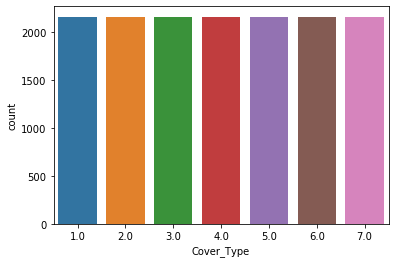

In [11]:
sns.countplot(x="Cover_Type", hue=None, data=X_all);

The target variable 'Cover_Type' consists of 7 classes of forest cover types. These classes have a uniform distribution in the training data set.

## 3.2 EDA: Analysis of features <a id='section_3.2'></a>

### EDA: 'Elevation'


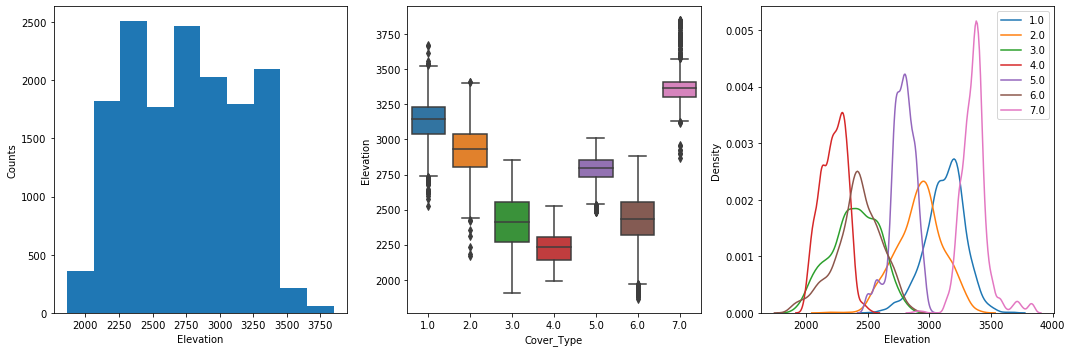

In [12]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,3,1)
plt.hist(X['Elevation'])
plt.xlabel('Elevation')
plt.ylabel('Counts')

plt.subplot(1,3,2)
sns.boxplot(x="Cover_Type", y="Elevation", hue=None, data=X);

plt.subplot(1,3,3)
for x in list(set(X['Cover_Type'])):
    ind_label=X[X['Cover_Type']==x].index
    sns.kdeplot(X.loc[ind_label,'Elevation'], label = x)
plt.xlabel('Elevation')
plt.ylabel('Density')

plt.tight_layout();

The target variable classes show a nice separation in terms of elevation. For example, cottonwood/willow trees (Cover_Type=4) occupy the lowest elevation areas, while krummholz trees (Cover_Type=7) occupy the highest elevations. 

### EDA: 'Aspect'
Aspect - Aspect in degrees azimuth

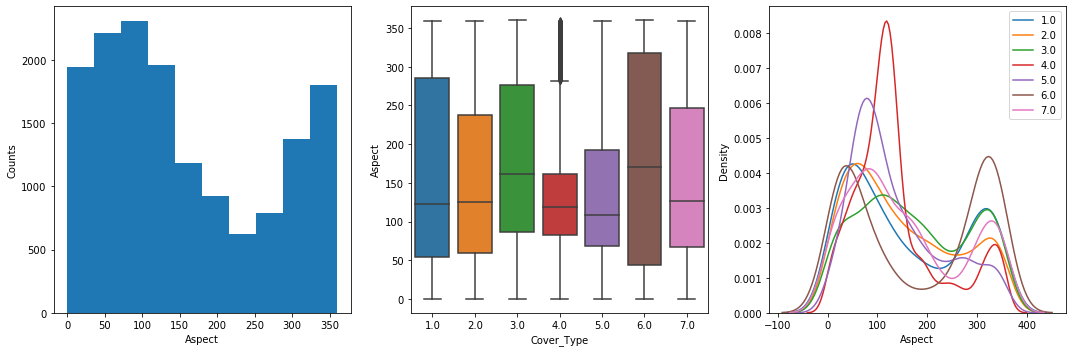

In [13]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,3,1)
plt.hist(X['Aspect'])
plt.xlabel('Aspect')
plt.ylabel('Counts')

plt.subplot(1,3,2)
sns.boxplot(x="Cover_Type", y="Aspect", hue=None, data=X)

plt.subplot(1,3,3)
for x in list(set(X['Cover_Type'])):
    ind_label=X[X['Cover_Type']==x].index
    sns.kdeplot(X.loc[ind_label,'Aspect'], label = x)
plt.xlabel('Aspect')
plt.ylabel('Density')

plt.tight_layout();

### EDA: 'Slope'
Slope - Slope in degrees

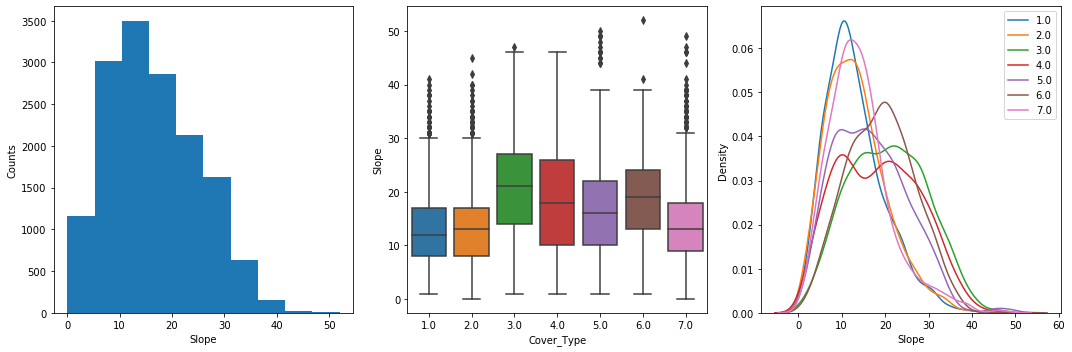

In [14]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,3,1)
plt.hist(X['Slope'])
plt.xlabel('Slope')
plt.ylabel('Counts')

plt.subplot(1,3,2)
sns.boxplot(x="Cover_Type", y="Slope", hue=None, data=X);

plt.subplot(1,3,3)
for x in list(set(X['Cover_Type'])):
    ind_label=X[X['Cover_Type']==x].index
    sns.kdeplot(X.loc[ind_label,'Slope'], label = x)
plt.xlabel('Slope')
plt.ylabel('Density')

plt.tight_layout();

Spruce/firs, lodgepole pines, and krummholz (Cover_Type=1,2,7) seem to prefer slightly less sloped areas than the other trees which inhabit a broader range of sloped landscapes.

### EDA: Distance to Hydrology
Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features  
Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features

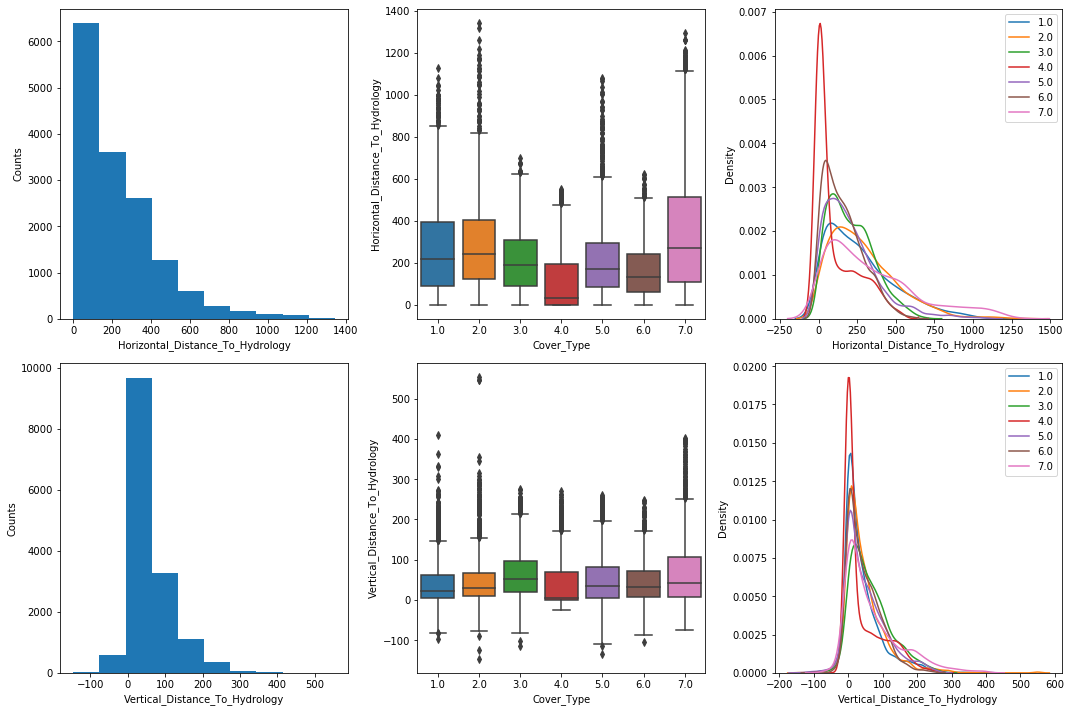

In [15]:
fig = plt.figure(figsize=(15, 10)) # (width,height)

### Horizontal_Distance_To_Hydrology

plt.subplot(2,3,1)
plt.hist(X['Horizontal_Distance_To_Hydrology'])
plt.xlabel('Horizontal_Distance_To_Hydrology')
plt.ylabel('Counts')

plt.subplot(2,3,2)
sns.boxplot(x="Cover_Type", y="Horizontal_Distance_To_Hydrology", hue=None, data=X);

plt.subplot(2,3,3)
for x in list(set(X['Cover_Type'])):
    ind_label=X[X['Cover_Type']==x].index
    sns.kdeplot(X.loc[ind_label,'Horizontal_Distance_To_Hydrology'], label = x)
plt.xlabel('Horizontal_Distance_To_Hydrology')
plt.ylabel('Density')

### Vertical_Distance_To_Hydrology

plt.subplot(2,3,4)
plt.hist(X['Vertical_Distance_To_Hydrology'])
plt.xlabel('Vertical_Distance_To_Hydrology')
plt.ylabel('Counts')

plt.subplot(2,3,5)
sns.boxplot(x="Cover_Type", y="Vertical_Distance_To_Hydrology", hue=None, data=X);

plt.subplot(2,3,6)
for x in list(set(X['Cover_Type'])):
    ind_label=X[X['Cover_Type']==x].index
    sns.kdeplot(X.loc[ind_label,'Vertical_Distance_To_Hydrology'], label = x)
plt.xlabel('Vertical_Distance_To_Hydrology')
plt.ylabel('Density')

plt.tight_layout();

Cottonwood/willow trees (Cover_Type=4) strongly prefer to be near water. Other types of trees show a much broader distribution of distances to water features. Krummholz (Cover_Type=7) can be found at the distances farthest from water -- the median horizontal distance to water for krummholz trees is 270 m, compared to a median distance of 30 m for cottonwood/willow trees.

In [16]:
X.groupby(['Cover_Type'])[['Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology']].median()

,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology
Cover_Type,,
1.0,218,23
2.0,242,31
3.0,190,51
4.0,30,6
5.0,170,35
6.0,134,33
7.0,270,42


### EDA: 'Horizontal_Distance_To_Roadways'
Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway

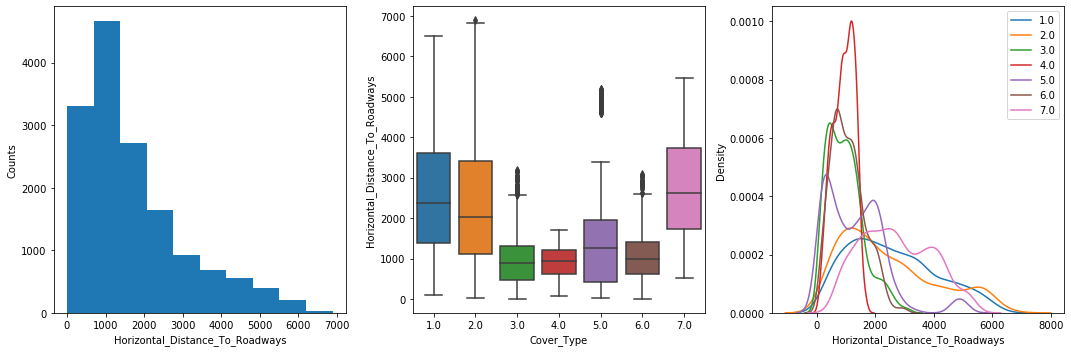

In [17]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,3,1)
plt.hist(X['Horizontal_Distance_To_Roadways'])
plt.xlabel('Horizontal_Distance_To_Roadways')
plt.ylabel('Counts')

plt.subplot(1,3,2)
sns.boxplot(x="Cover_Type", y="Horizontal_Distance_To_Roadways", hue=None, data=X);

plt.subplot(1,3,3)
for x in list(set(X['Cover_Type'])):
    ind_label=X[X['Cover_Type']==x].index
    sns.kdeplot(X.loc[ind_label,'Horizontal_Distance_To_Roadways'], label = x)
plt.xlabel('Horizontal_Distance_To_Roadways')
plt.ylabel('Density')

plt.tight_layout();

Ponderosa pine, cottonwood/willow, and douglas fir trees (Cover_Type=3,4,6) can all be found within 2000 meters of a roadway.

Spruce/firs (Cover_Type=1) and lodgepole pines (Cover_Type=2) seem to be located at farther distances from roadways, and krummholz trees (Cover_Type=7) are the most remote.

In [18]:
X.groupby(['Cover_Type'])['Horizontal_Distance_To_Roadways'].median()

Cover_Type
1.0    2377.0
2.0    2023.5
3.0     897.0
4.0     942.0
5.0    1253.5
6.0     993.0
7.0    2611.5
Name: Horizontal_Distance_To_Roadways, dtype: float64

### EDA: 'Horizontal_Distance_To_Fire_Points'
Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points

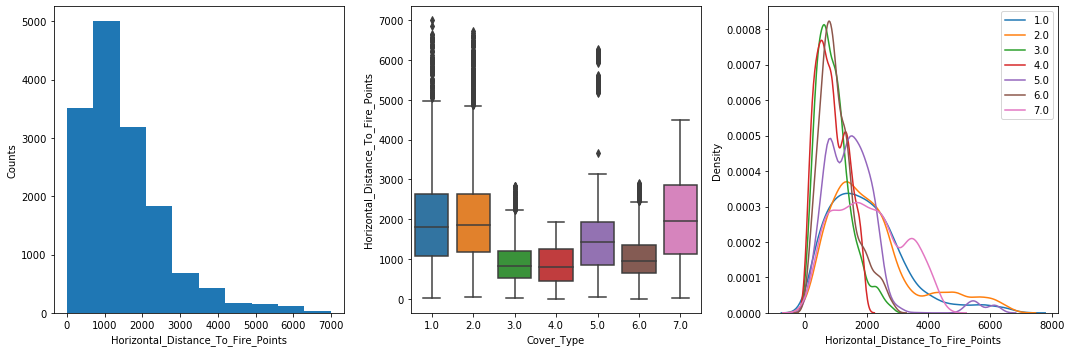

In [19]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,3,1)
plt.hist(X['Horizontal_Distance_To_Fire_Points'])
plt.xlabel('Horizontal_Distance_To_Fire_Points')
plt.ylabel('Counts')

plt.subplot(1,3,2)
sns.boxplot(x="Cover_Type", y="Horizontal_Distance_To_Fire_Points", hue=None, data=X);

plt.subplot(1,3,3)
for x in list(set(X['Cover_Type'])):
    ind_label=X[X['Cover_Type']==x].index
    sns.kdeplot(X.loc[ind_label,'Horizontal_Distance_To_Fire_Points'], label = x)
plt.xlabel('Horizontal_Distance_To_Fire_Points')
plt.ylabel('Density')

plt.tight_layout();

Ponderosa pines, cottonwood/willows, and douglas firs (Cover_Types=3,4,6) are located preferentially closer to fire points compared to spruce/firs, lodgepole pines, and krummholz (Cover_Types=1,2,7).

### EDA: Hillshade
Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice  
Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice  
Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice

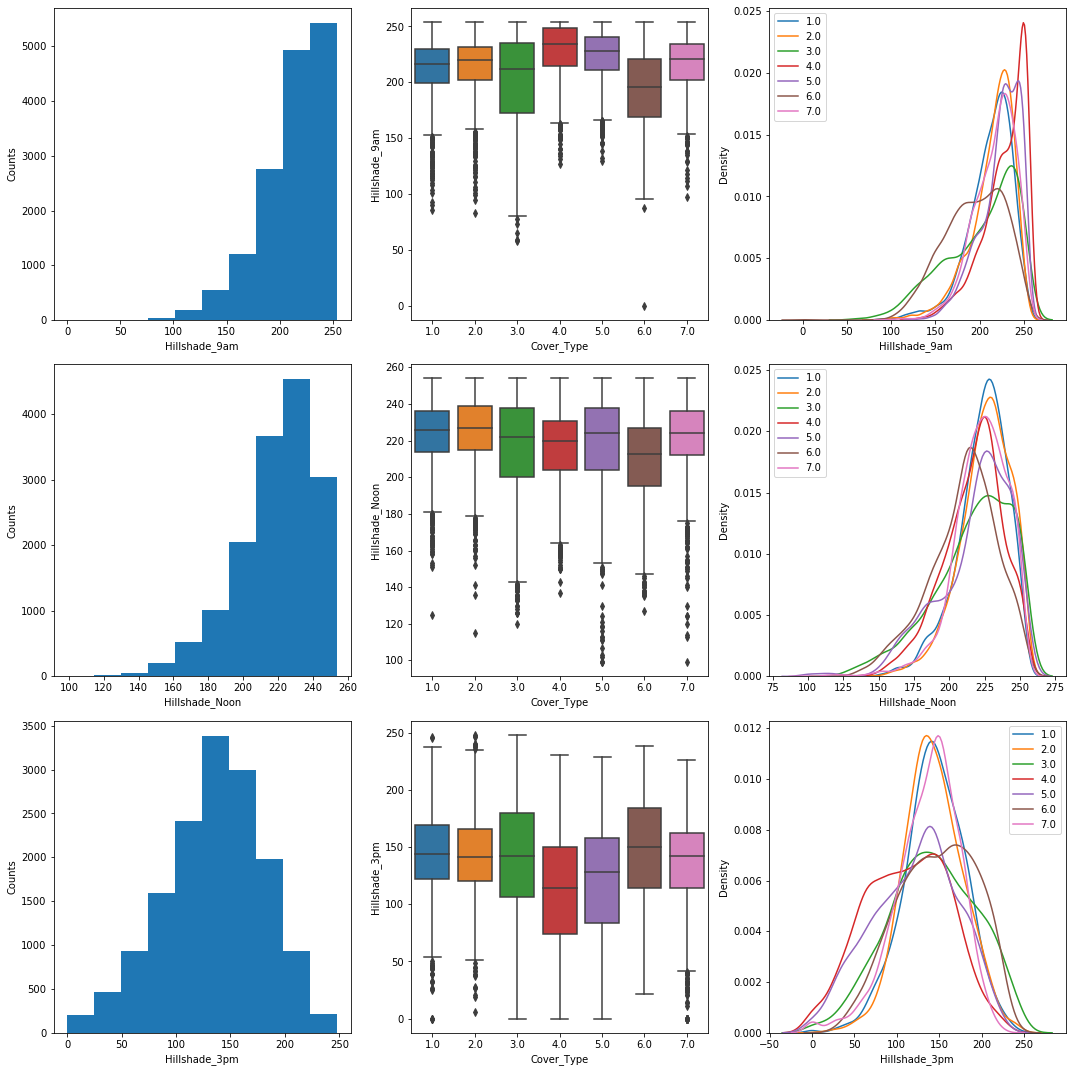

In [20]:
fig = plt.figure(figsize=(15, 15)) # (width,height)

### Hillshade_9am 
plt.subplot(3,3,1)
plt.hist(X['Hillshade_9am'])
plt.xlabel('Hillshade_9am')
plt.ylabel('Counts')

plt.subplot(3,3,2)
sns.boxplot(x="Cover_Type", y="Hillshade_9am", hue=None, data=X);

plt.subplot(3,3,3)
for x in list(set(X['Cover_Type'])):
    ind_label=X[X['Cover_Type']==x].index
    sns.kdeplot(X.loc[ind_label,'Hillshade_9am'], label = x)
plt.xlabel('Hillshade_9am ')
plt.ylabel('Density')

### Hillshade_Noon 

plt.subplot(3,3,4)
plt.hist(X['Hillshade_Noon'])
plt.xlabel('Hillshade_Noon')
plt.ylabel('Counts')

plt.subplot(3,3,5)
sns.boxplot(x="Cover_Type", y="Hillshade_Noon", hue=None, data=X);

plt.subplot(3,3,6)
for x in list(set(X['Cover_Type'])):
    ind_label=X[X['Cover_Type']==x].index
    sns.kdeplot(X.loc[ind_label,'Hillshade_Noon'], label = x)
plt.xlabel('Hillshade_Noon')
plt.ylabel('Density')


### Hillshade_3pm 

plt.subplot(3,3,7)
plt.hist(X['Hillshade_3pm'])
plt.xlabel('Hillshade_3pm')
plt.ylabel('Counts')

plt.subplot(3,3,8)
sns.boxplot(x="Cover_Type", y="Hillshade_3pm", hue=None, data=X);

plt.subplot(3,3,9)
for x in list(set(X['Cover_Type'])):
    ind_label=X[X['Cover_Type']==x].index
    sns.kdeplot(X.loc[ind_label,'Hillshade_3pm'], label = x)
plt.xlabel('Hillshade_3pm')
plt.ylabel('Density')

plt.tight_layout();

### EDA: 'WildernessArea'
Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation

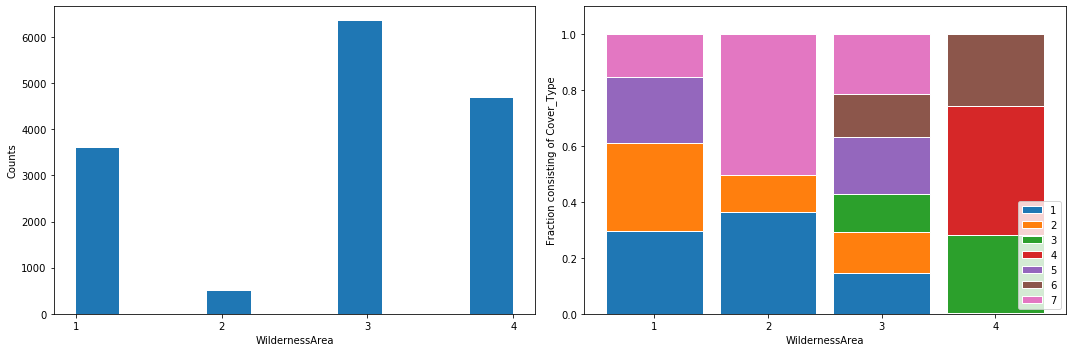

In [21]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,2,1)
plt.hist(X['WildernessArea'].sort_values())
plt.xlabel('WildernessArea')
plt.ylabel('Counts')

plt.subplot(1,2,2)

r = np.sort(list(set(X['WildernessArea'])))
df = pd.crosstab(X['WildernessArea'], X['Cover_Type'], normalize='index')

barWidth = 0.85
bottom = np.zeros(len(r))
colors = sns.color_palette().as_hex()
for x in [1,2,3,4,5,6,7]:
    plt.bar(r, df[x], bottom=bottom, color=colors[x-1],edgecolor='white', width=barWidth, label=x)
    bottom=np.array(bottom)+np.array(df[x])

plt.xlabel('WildernessArea')
plt.ylabel('Fraction consisting of Cover_Type')
plt.legend(loc=4)
plt.ylim(0,1.1)


plt.tight_layout();

In [22]:
pd.crosstab(X['Cover_Type'], X['WildernessArea'], normalize='index')

WildernessArea,1,2,3,4
Cover_Type,,,,
1.0,0.491667,0.083796,0.424537,0.000000
2.0,0.525000,0.030556,0.435185,0.009259
3.0,0.000000,0.000000,0.399537,0.600463
4.0,0.000000,0.000000,0.000000,1.000000
5.0,0.396296,0.000000,0.603704,0.000000
6.0,0.000000,0.000000,0.445370,0.554630
7.0,0.252315,0.116667,0.631019,0.000000


Most observations in the training set occur in the Comanche Peak Wilderness Area (WildernessArea=3). Very few observations in the training set are from Neota Wilderness Area (WildernessArea=2).

The different wilderness areas likely are of different ecosystems and terrains such that different types of trees prefer different regions. 

For example cottonwood/willow trees (Cover_Type=4), which we have seen in the training set to prefer living close to water, are only observed in the Cache la Poudre Wilderness Area (WildernessArea=4) which runs along the Cache la Poudre River.

In comparison the Neota Wilderness Area (WildernessArea=2), an area at elevation >10,000 ft, consists of over 50% krummholz trees (Cover_Type=7) which we have seen in the training set to prefer inhabiting high elevations.

### EDA: 'SoilType'
Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation

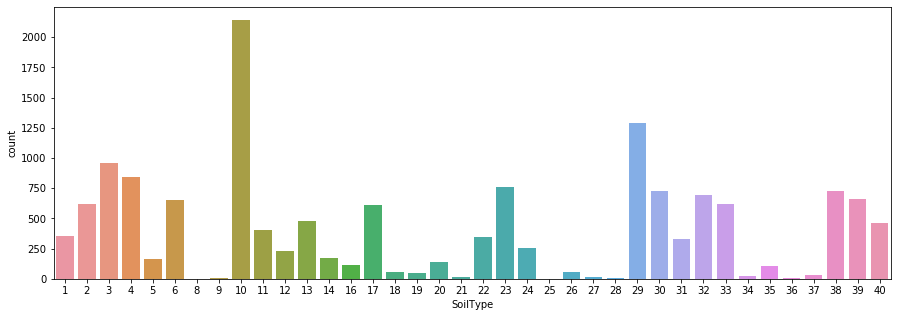

In [23]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

sns.countplot(x="SoilType", hue=None,data=X,
             order=[str(xx) for xx in np.sort([int(x) for x in X['SoilType'].unique()])]);

In [24]:
pd.crosstab(X['Cover_Type'], X['SoilType'], normalize='index')

SoilType,1,10,11,12,13,14,16,17,18,19,...,36,37,38,39,4,40,5,6,8,9
Cover_Type,,,,,,,,,,,,,,,,,,,,,
1.0,0.000000,0.004167,0.002315,0.011111,0.007870,0.000000,0.004167,0.000926,0.000000,0.006944,...,0.000000,0.000000,0.037037,0.036574,0.002315,0.022685,0.000000,0.000000,0.000000,0.000463
2.0,0.000000,0.037500,0.031019,0.093981,0.038889,0.000000,0.006481,0.003241,0.007407,0.006019,...,0.000926,0.000000,0.003241,0.001389,0.009259,0.001389,0.000000,0.003241,0.000463,0.004167
3.0,0.056019,0.331944,0.041204,0.000000,0.001852,0.001852,0.002315,0.015741,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.213889,0.000000,0.025463,0.114815,0.000000,0.000000
4.0,0.064352,0.078704,0.011111,0.000000,0.000000,0.059259,0.018519,0.162037,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.061574,0.000000,0.018056,0.112963,0.000000,0.000000
5.0,0.000000,0.029630,0.071296,0.000000,0.141204,0.000000,0.004167,0.060648,0.020370,0.008333,...,0.000000,0.000000,0.000000,0.000000,0.059722,0.000000,0.000000,0.000000,0.000000,0.000000
6.0,0.043981,0.509722,0.031019,0.000000,0.030556,0.017130,0.017130,0.040741,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.040278,0.000000,0.032870,0.069907,0.000000,0.000000
7.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003704,0.015741,0.296759,0.266204,0.003241,0.188426,0.000000,0.000000,0.000000,0.000000


## 3.3 EDA: Correlation analysis <a id='section_3.3'></a>
- [3.3.1 Feature - Target Correlation](#section_3.3.1)  
- [3.3.2 Feature - Feature Correlation](#section_3.3.2)  

### 3.3.1 Feature  - Target Correlation <a id='section_3.3.1'></a>
Here the Kruskal–Wallis H-test is used to examine if the 'Cover_Type' classes have different distributions in terms of the continuous numeric features of the data set.

In [25]:
# Kruskal-Wallis H-test
from scipy import stats

df_kruskal = pd.DataFrame(columns=['col','f','p'])
for index, col in enumerate(num_cols):
    f, p = stats.kruskal(*[y.loc[X[X[col]==x].index] for x in set(X[col])])
    df_kruskal = df_kruskal.append({'col': col , 'f': f, 'p': p} , ignore_index=True)
df_kruskal = df_kruskal.sort_values(by='f', ascending=False)
df_kruskal

,col,f,p
6,Elevation,6686.615025,0.000000e+00
1,Horizontal_Distance_To_Roadways,4824.222689,1.390974e-65
4,Horizontal_Distance_To_Fire_Points,3810.076759,9.171612e-41
5,Horizontal_Distance_To_Hydrology,783.447640,2.763988e-27
3,Vertical_Distance_To_Hydrology,595.739630,4.754042e-08
9,Aspect,459.178204,3.052071e-04
2,Hillshade_3pm,321.745842,8.282830e-04
8,Hillshade_Noon,258.840202,4.088540e-09
7,Hillshade_9am,254.751606,7.801772e-05
0,Slope,202.566207,5.997744e-20


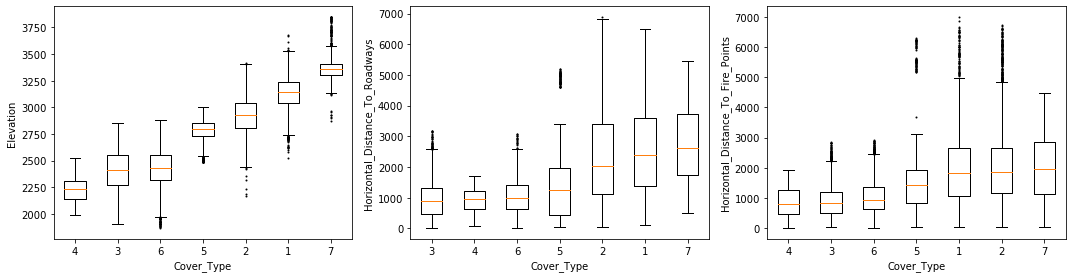

In [26]:
# Boxplots for those features with highest kruskal score

fig = plt.figure(figsize=(15, 15)) # (width,height)

outlier_marker = dict(markerfacecolor='k', marker='.', markersize=2)

for index, col in enumerate(df_kruskal['col'][:3]):
    ax = fig.add_subplot(4, 3, index+1)

    data = []
    y_vals = y.unique()
    
    med_list = []
    for y_val in y_vals:
        xx = X.loc[y[y==y_val].index,col].values
        data.append(xx)
        med_list.append(np.median(xx))
        
    df_plot = pd.DataFrame({'y_vals': y_vals, 'median': med_list, 'data': data})
    df_plot = df_plot.sort_values(by='median')
    
    plt.boxplot(df_plot['data'], flierprops=outlier_marker)
    
    locs=ax.get_xticks()
    plt.xticks(locs, df_plot['y_vals'])

    plt.ylabel(col)
    plt.xlabel('Cover_Type')
plt.tight_layout()

'Elevation', 'Horizontal_Distance_To_Roadways', and 'Horizontal_Distance_To_Fire_Points' are the features showing the best separation of target populations. Spruce/firs, lodgepole pines, and krummholz (Cover_Type=1,2,7) are more likely to be the dominating forest cover at high elevations, areas farther from roadways, and areas farther from fire points. Ponderosa pines, cottonwood/willows, and douglas firs (Cover_Type=3,4,6) are more likely to be the dominant forest cover at lower elevations, closer to roadways and fire points. Aspens (Cover_Type=5) typically inhabit the middle areas of these distributions.

### 3.3.2 Feature  - Feature Correlation <a id='section_3.3.2'></a>

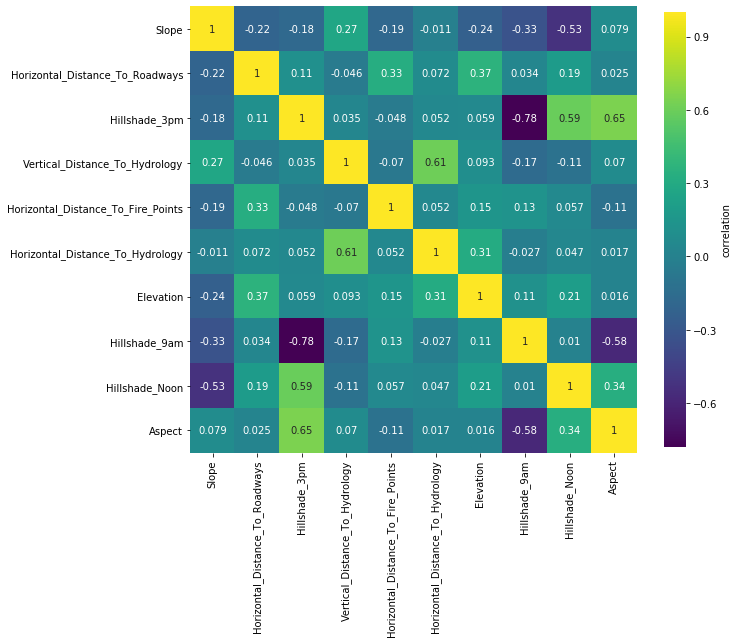

In [27]:
# Plot correlation map of features

fig = plt.figure(figsize=(10, 10)) # (width,height)
corr_map = X_all[num_cols].corr()
sns.heatmap(corr_map, cmap='viridis', square=True, 
            annot=True, annot_kws={'size': 10}, cbar_kws={'shrink': 0.8,'label': 'correlation'});

In [28]:
# Identify collinearity in features

corr = X_all[num_cols].corr()
df_corr = pd.DataFrame(columns=['feat1','feat2','corr(feat1,feat2)'])
corr_high = corr[(np.abs(corr)<1)&(np.abs(corr)>0.)]
for col in corr_high.columns: 
    if corr_high[col].count()>0:
        dat = corr_high[col]
        for ii in range(0,len(dat[dat.notnull()].keys())):
            df_corr = df_corr.append({'feat1': col,
                                      'feat2': dat[dat.notnull()].keys()[ii], 
                                      'corr(feat1,feat2)': dat[dat.notnull()].values[ii]}, 
                                      ignore_index=True)
cols_collinear = df_corr['feat1'].unique()
df_corr = df_corr.sort_values(by='corr(feat1,feat2)', ascending=False).drop_duplicates(subset='corr(feat1,feat2)', keep='first')

In [29]:
pd.DataFrame(pd.concat([df_corr[:5],df_corr[-5:]]))

,feat1,feat2,"corr(feat1,feat2)"
83,Aspect,Hillshade_3pm,0.646944
31,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Hydrology,0.606236
74,Hillshade_Noon,Hillshade_3pm,0.594274
14,Horizontal_Distance_To_Roadways,Elevation,0.365559
89,Aspect,Hillshade_Noon,0.336103
5,Slope,Elevation,-0.242697
6,Slope,Hillshade_9am,-0.327199
72,Hillshade_Noon,Slope,-0.526911
71,Hillshade_9am,Aspect,-0.579273
24,Hillshade_3pm,Hillshade_9am,-0.780296


Some of the strongest correlations between features occur for Hillshade, slope, and aspect. The calculation of Hillshade depends on slope and aspect so the strong correlations between these features is not too surprising. 

It's also worth noting the weak positive correlation between 'Horizontal_Distance_To_Roadways' and 'Elevation' - higher elevation points are more remote and farther from roads. 

# 4. Feature Engineering <a id='section_4'></a>

[4.1 Total distance to hydrology](#section_4.1)   
[4.2 Total shade](#section_4.2)  
[4.3 Feature interaction terms](#section_4.3)   
[4.4 Summary of new created features](#section_4.4) 

## 4.1 Total distance to hydrology <a id='section_4.1'></a>

In [30]:
X_all['Distance_To_Hydrology']=np.sqrt((X_all['Horizontal_Distance_To_Hydrology']**2.)+(X_all['Vertical_Distance_To_Hydrology']**2.))

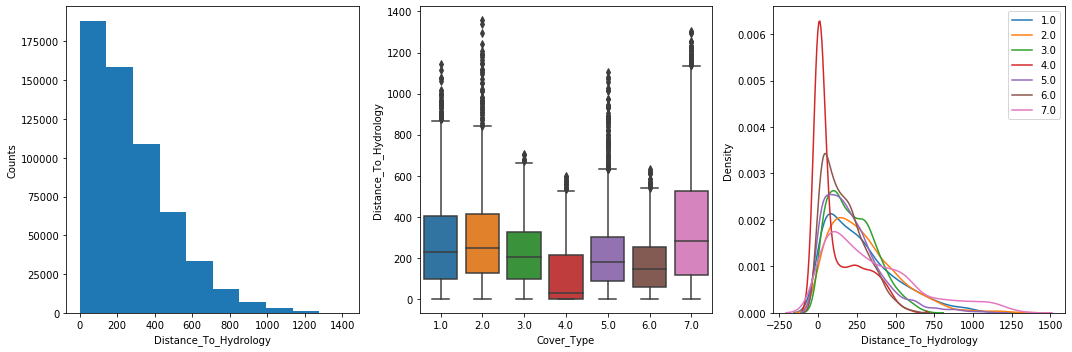

In [31]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,3,1)
plt.hist(X_all['Distance_To_Hydrology'])
plt.xlabel('Distance_To_Hydrology')
plt.ylabel('Counts')

plt.subplot(1,3,2)
sns.boxplot(x="Cover_Type", y="Distance_To_Hydrology", hue=None, data=X_all);

plt.subplot(1,3,3)
for x in list(set(X['Cover_Type'])):
    ind_label=X_all[X_all['Cover_Type']==x].index
    sns.kdeplot(X_all.loc[ind_label,'Distance_To_Hydrology'], label = x)
plt.xlabel('Distance_To_Hydrology')
plt.ylabel('Density')

plt.tight_layout();

Combining the vertical and horizontal distances to hydrology greatly distinguishes how cottonwood/willow trees (Cover_Type=4) strongly prefer to be close to water compared to the other tree types.

## 4.2 Total shade <a id='section_4.2'></a>

In [32]:
X_all['Hillshade_total'] = X_all['Hillshade_9am']+X_all['Hillshade_Noon']+X_all['Hillshade_3pm']
X_all['Hillshade_mul'] = (X_all['Hillshade_9am']**2)*(X_all['Hillshade_Noon']**2)*(X_all['Hillshade_3pm']**2)

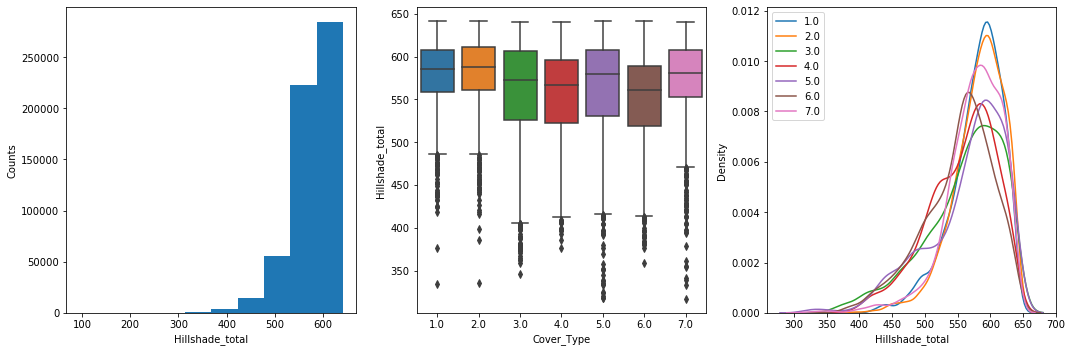

In [33]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,3,1)
plt.hist(X_all['Hillshade_total'])
plt.xlabel('Hillshade_total')
plt.ylabel('Counts')

plt.subplot(1,3,2)
sns.boxplot(x="Cover_Type", y="Hillshade_total", hue=None, data=X_all);

plt.subplot(1,3,3)
for x in list(set(X['Cover_Type'])):
    ind_label=X_all[X_all['Cover_Type']==x].index
    sns.kdeplot(X_all.loc[ind_label,'Hillshade_total'], label = x)
plt.xlabel('Hillshade_total')
plt.ylabel('Density')

plt.tight_layout();

The distributions of total shade are fairly simlar between 'Cover_Type' classes; this might not be the most useful feature.

## 4.3 Feature interaction terms <a id='section_4.3'></a>
I only added interaction terms that increased the score of a baseline ExtraTreesClassifier model.

In [34]:
from sklearn.ensemble import ExtraTreesClassifier

# A function to calculate a quick baseline score 
def baseline_score(X,y):
    model = ExtraTreesClassifier(max_depth=10,random_state=0).fit(X,y)
    return model.score(X, y)

In [35]:
X_all['E*DR'] = X_all['Elevation']*X_all['Horizontal_Distance_To_Roadways']
X_all['E*DF'] = X_all['Elevation']*X_all['Horizontal_Distance_To_Fire_Points']
X_all['E*DH'] = X_all['Elevation']*X_all['Horizontal_Distance_To_Hydrology']
X_all['SRSS(DR,DF,DH)'] = np.sqrt((X_all['Horizontal_Distance_To_Roadways']**2)
                                  +(X_all['Horizontal_Distance_To_Fire_Points']**2)
                                  +(X_all['Horizontal_Distance_To_Hydrology']**2))

X_all['SoilType'] = pd.to_numeric(X_all['SoilType'])
X_all['WildernessArea'] = pd.to_numeric(X_all['WildernessArea'])
X_all['ST*W'] = X_all['SoilType']*X_all['WildernessArea']

## 4.4 Summary of new created features <a id='section_4.4'></a>

In [36]:
# New features list
new_cols = list(set(X_all.columns)-set(X.columns))


# New nominal features - need to be encoded like nominal data
catnom_cols_new = [col for col in new_cols if
                   X_all[col].dtype == "object"]

# New numerical features
num_cols_new = [col for col in new_cols if 
                X_all[col].dtype in ['int64', 'float64']]


In [37]:
new_cols

['SRSS(DR,DF,DH)',
 'Hillshade_mul',
 'ST*W',
 'E*DF',
 'Hillshade_total',
 'E*DR',
 'Distance_To_Hydrology',
 'E*DH']

In [38]:
num_cols_new

['SRSS(DR,DF,DH)',
 'Hillshade_mul',
 'ST*W',
 'E*DF',
 'Hillshade_total',
 'E*DR',
 'Distance_To_Hydrology',
 'E*DH']

In [39]:
# Separate train and test data
X_new = X_all[:X.shape[0]].drop('Cover_Type', axis=1)
X_test_new = X_all[X.shape[0]:].drop('Cover_Type', axis=1)
print('Check train and test index labels match originals:', set(X_new.index==X.index), set(X_test_new.index==X_test.index))

Check train and test index labels match originals: {True} {True}


# 5. Data pre-processing <a id='section_5'></a>

[5.1 Assessing the encoding of nominal features](#section_5.1)   
[5.2 Skewed features and log transforms](#section_5.2)   
[5.3 sklearn Pipeline for pre-processing](#section_5.3)  
[5.4 Final prepping of the data before modeling](#section_5.4)  

## 5.1 Assessing the encoding of nominal features <a id='section_5.1'></a>

In [40]:
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

# Ordinal Encoding 
X_temp=X.copy().drop('Cover_Type',axis=1)
X_temp['WildernessArea'] = pd.to_numeric(X_temp['WildernessArea'])
X_temp['SoilType'] = pd.to_numeric(X_temp['SoilType'])
print('Ordinal Encoding score:',baseline_score(X_temp,y))

# Count Encoding
X_temp=X.copy().drop('Cover_Type',axis=1)
X_temp[catnom_cols] = ce.CountEncoder().fit_transform(X_temp[catnom_cols])
print('Count Encoding score:',baseline_score(X_temp,y))

# Target Encoding
X_temp=X.copy().drop('Cover_Type',axis=1)
enc = ce.TargetEncoder().fit(X_temp[catnom_cols],y)
X_temp[catnom_cols] = enc.transform(X_temp[catnom_cols])
print('Target Encoding score:',baseline_score(X_temp,y))

# CatBoost Encoding
X_temp=X.copy().drop('Cover_Type',axis=1)
enc = ce.CatBoostEncoder().fit(X_temp[catnom_cols],y)
X_temp[catnom_cols] = enc.transform(X_temp[catnom_cols])
print('CatBoost Encoding score:',baseline_score(X_temp,y))

# OneHot Encoding
X_temp=X.copy().drop('Cover_Type',axis=1)
enc = ce.OneHotEncoder().fit(X_temp[catnom_cols],y)
X_nom_enc = enc.transform(X_temp[catnom_cols])
X_temp_enc = pd.concat([X_temp[num_cols],X_nom_enc],axis=1)
print('One-Hot Encoding score:',baseline_score(X_temp_enc,y))

# Combine ordinal for SoilType and onehot for WildernessArea
X_temp=X.copy().drop('Cover_Type',axis=1)

X_temp['SoilType'] = pd.to_numeric(X_temp['SoilType']) # ordinal encoding for SoilType

enc = ce.OneHotEncoder().fit(X_temp['WildernessArea'],y) # onehot encoding for WildernessArea
X_nom_enc = enc.transform(X_temp['WildernessArea'])
X_temp_enc = pd.concat([X_temp[num_cols+['SoilType']],X_nom_enc],axis=1)
print('Combined score:',baseline_score(X_temp_enc,y))

Ordinal Encoding score: 0.8226851851851852
Count Encoding score: 0.8117063492063492
Target Encoding score: 0.817989417989418
CatBoost Encoding score: 0.8156746031746032
One-Hot Encoding score: 0.7759920634920635
Combined score: 0.8093915343915344


Ordinal encoding the nominal features produces the best classification accuracy using a baseline ExtraTreesClassifier model. 'WildernessArea' and 'SoilType' are already in an ordinal encoded form, so there's no need to reapply the encoding.

In [41]:
# Keeping the ordinal encoding of nominal features and converting values from categorial type to numeric

X_all['WildernessArea'] = pd.to_numeric(X_all['WildernessArea'])
X_all['SoilType'] = pd.to_numeric(X_all['SoilType'])

X_new['WildernessArea'] = pd.to_numeric(X_new['WildernessArea'])
X_new['SoilType'] = pd.to_numeric(X_new['SoilType'])

X_test_new['WildernessArea'] = pd.to_numeric(X_test_new['WildernessArea'])
X_test_new['SoilType'] = pd.to_numeric(X_test_new['SoilType'])


## 5.2 Skewed features and log transforms <a id='section_5.2'></a>
Determine the skew of numeric features and assess if performing a log(1+x) transform is effective at reducing skew.

In [42]:
from scipy.stats import skew
from scipy.stats import skewtest
from scipy.stats import boxcox
from scipy.stats import pearsonr
from scipy.stats import yeojohnson

df = pd.DataFrame(columns=['features', 'skewtest_pval', 'col_skew', 'log1p_skew', 'yj_skew', 
                           'pdiff(col_skew,log1p_skew)', 'change'])
for i, col in enumerate(num_cols+num_cols_new):

    transform = 'log_transform' #yj_transform, log_transform
    
    pval = skewtest(X_all[col])[1]
    col_skew = X_all[col].skew()
    
    lp_skew = np.log1p(X_all[col]).skew() # log(1+x) transform
    
    
    pdiff = np.abs(np.abs(col_skew)-np.abs(lp_skew))/np.abs(col_skew) # percent difference
    
    yj_skew = skew(yeojohnson(X_all[col])[0]) # yeo-johnson transform
    pdiff2 =np.abs(np.abs(col_skew)-np.abs(yj_skew))/np.abs(col_skew)
    
    r2before = np.round(X_all[col].corr(y),decimals=2)
    
    # is a transform of the column effective at reducing skew?
    change=0
    if transform == 'log_transform':
        r2after = np.round(np.log1p(X_all[col]).corr(y), decimals=2)
        if (pval<0.05) and (pdiff>0.05) and (np.abs(lp_skew)<np.abs(col_skew)):  # for log(1+x) transform
            change=1
        
    if transform == 'yj_transform':
        if (pval<0.05) and (pdiff2>0.1) and (np.abs(yj_skew)<np.abs(col_skew)): # yeo-johnson transform
            change=1
               
    df.loc[i]=[col, pval, col_skew, lp_skew, yj_skew, pdiff, change]

df = df.sort_values(by='col_skew', ascending=False)

skewed_cols = list(set(df[df['change']==1]['features']))

df

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,features,skewtest_pval,col_skew,log1p_skew,yj_skew,"pdiff(col_skew,log1p_skew)",change
3,Vertical_Distance_To_Hydrology,0.000000e+00,1.790250,NaN,0.331549,NaN,0
17,E*DH,0.000000e+00,1.313245,-3.847978,-0.337918,1.930128,0
4,Horizontal_Distance_To_Fire_Points,0.000000e+00,1.288644,-0.797234,0.000418,0.381339,1
13,E*DF,0.000000e+00,1.141830,-1.389342,-0.015871,0.216768,0
5,Horizontal_Distance_To_Hydrology,0.000000e+00,1.140437,-2.133443,-0.104404,0.870723,0
16,Distance_To_Hydrology,0.000000e+00,1.133469,-2.148885,-0.107095,0.895847,0
0,Slope,0.000000e+00,0.789273,-0.695571,-0.014085,0.118719,1
15,E*DR,0.000000e+00,0.734317,-1.853594,-0.078999,1.524244,0
1,Horizontal_Distance_To_Roadways,0.000000e+00,0.713679,-0.994705,-0.070878,0.393771,0
10,"SRSS(DR,DF,DH)",0.000000e+00,0.712661,-0.549327,-0.029935,0.229188,1


In [43]:
print('Features that benefit from a log transform: \n',skewed_cols)

Features that benefit from a log transform: 
 ['SRSS(DR,DF,DH)', 'Slope', 'ST*W', 'Horizontal_Distance_To_Fire_Points']


## 5.3 sklearn Pipeline for pre-processing <a id='section_5.3'></a>

This pipeline setup will take care of the scaling of features within the cross-validation of a model.

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])  


# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols)
    ])

## 5.4 Final prepping of the data before modeling <a id='section_5.4'></a>

In [45]:
X_clean = X_new.copy()
y_clean = y.copy()
X_test_clean = X_test_new.copy()

# Transforming skewed columns 
for col in skewed_cols:
    X_clean[col] = np.log1p(X_clean[col]) 
    X_test_clean[col] = np.log1p(X_test_clean[col]) 
    
# Removing columns for any reason
cols_remove = [] #['Slope','Hillshade_total','Vertical_Distance_To_Hydrology']
X_clean = X_clean.drop(cols_remove, axis=1)
X_test_clean = X_test_clean.drop(cols_remove, axis=1)

# Revising list of features to take into account the addition of new features
num_cols_final = [x for x in list(set(list(num_cols)+list(num_cols_new))-set(cols_remove)) if x in X_clean.columns]
catnom_cols_final = [x for x in list(set(list(catnom_cols)+list(catnom_cols_new))-set(cols_remove)) if x in X_clean.columns]


# 6. Modeling with ExtraTreesClassifier <a id='section_6'></a>

[6.1 Feature selection](#section_6.1)   
[6.2 Fitting the model](#section_6.2)   
[6.3 Making predictions on the test set](#section_6.3)  

Here I include the process of fitting an ExtraTreesClassifier model to the data. Model hyperparameters have been tuned using RandomizedSearchCV to produce the highest mean cross-validated accuracy score.

While working on this problem, I also tried implementing a few other models including: RidgeClassifier, SVC, RandomForestClassifier, LGBMClassifier, XGBClassifier, and GradientBoostingClassifier. While the tree-based models generally performed well, ExtraTreesClassifier returned the highest accuracy score. Attempts at using a voting ensemble of the best fitting models did not result an improvement in accuracy over just a singular ExtraTreesClassifier model.


## 6.1 Feature selection <a id='section_6.1'></a>
To improve the generalization of my model, I reduce the number of features through recursive feature elimination.

dropped columns: ['Slope', 'Hillshade_mul', 'Hillshade_3pm', 'Hillshade_total', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Hydrology', 'Hillshade_Noon']


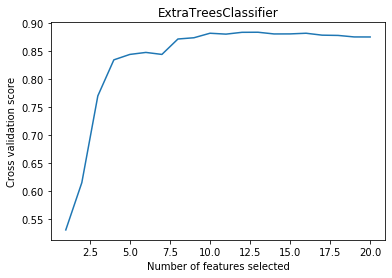

In [46]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold


model = ExtraTreesClassifier(n_estimators=100, random_state=0)
model_label = 'ExtraTreesClassifier'


# Recursive feature elimination
rfecv = RFECV(estimator=model, step=1, 
              cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0), 
              scoring='accuracy',
              n_jobs=-1)
rfecv.fit(X_clean, y_clean)
   

# Dataframe to store the feature ranking according to RFE
ranking_df = pd.DataFrame()
ranking_df['feature'] = X_clean.columns
ranking_df[model_label] = rfecv.ranking_
  
# Features to keep and features to drop based on RFE        
keep_cols = list(X_clean.columns[rfecv.get_support(indices=True)])
drop_cols = list(set(X_clean.columns)-set(keep_cols))
print('dropped columns:',drop_cols)

    
# Clean up data sets
X_selected = X_clean[keep_cols]
X_test_selected = X_test_clean[keep_cols]

# Plot number of features VS. cross-validation scores
plt.subplot(1,1,1)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.title(model_label)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_);

## 6.2 Fitting the model <a id='section_6.2'></a>

In [47]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

model = ExtraTreesClassifier(n_estimators=300,
                             min_samples_leaf=1,
                             max_depth=None,
                             max_features=0.6,
                             random_state=0)

# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X_selected.columns),
    ])

# Pipeline for preprocessing and modeling
ext_clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

# Apply preprocessing and train model 
ext_clf.fit(X_selected, y_clean)

# Cross validation scores for model
scores = cross_val_score(ext_clf, 
                         X_selected, y_clean, 
                         scoring='accuracy', 
                         cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=0),n_jobs=-1) 


print("ExtraTreesClassifier Mean CV score: {} +/- {}".format(np.round(np.mean(scores),5),np.round(np.std(scores),4)))


ExtraTreesClassifier Mean CV score: 0.88638 +/- 0.004


## 6.3 Making predictions on the test set <a id='section_6.3'></a>

In [48]:
# Saving ExtraTreesClassifier predictions on the test data
y_test_ext = ext_clf.predict(X_test_selected)
output = pd.DataFrame({'Id': X_test_selected.index, 
                       'Cover_Type': y_test_ext})
output.to_csv('./output/submission_ext_selected.csv', index=False)

# 7. Results of modeling <a id='section_7'></a>

[7.1 Feature importances](#section_7.1)   
[7.2 Distribution of predicted classes](#section_7.2)   
[7.3 Accuracy of model classification](#section_7.3)  


## 7.1 Feature importances <a id='section_7.1'></a>

In [49]:
# Feature names from the preprocessor 
clf_num = ext_clf.named_steps['preprocessor'].transformers_[0][2] 

# Creating dataframe of features sorted by importance
ext_fi = pd.concat([pd.Series(list(clf_num), name='feature'), 
                    pd.Series(ext_clf.named_steps['model'].feature_importances_, name='importance')], 
                    axis=1).sort_values(by='importance', ascending=False)

print('Features selected by ExtraTreesClassifier:', len(np.where(ext_fi['importance']!=0)[0]), '/', len(ext_fi))
print('Fraction of features selected by ExtraTreesClassifier:', np.round(len(np.where(ext_fi['importance']!=0)[0])/len(ext_fi),2))
print('Minimum feature importance:',np.round(min(ext_fi['importance'][ext_fi['importance']!=0]),3))
ext_fi.head()


Features selected by ExtraTreesClassifier: 13 / 13
Fraction of features selected by ExtraTreesClassifier: 1.0
Minimum feature importance: 0.046


,feature,importance
0,Elevation,0.224197
6,SoilType,0.146925
5,WildernessArea,0.080154
12,ST*W,0.076993
8,E*DR,0.062070


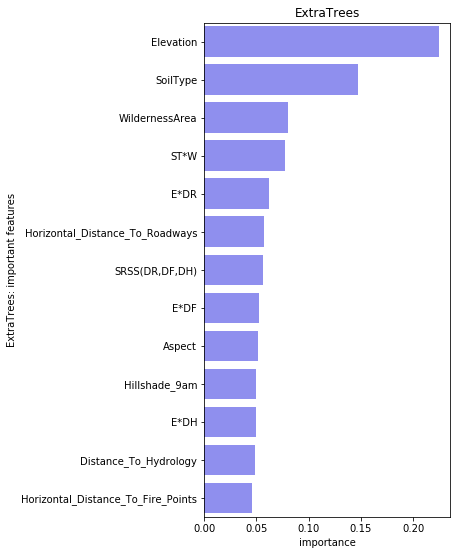

In [50]:
# Plotting feature importances 

fig = plt.figure(figsize=(15, 20)) # (width,height)

'''
ExtraTreesClassifier feature importances
'''
ax = plt.subplot(2,3,2)
rf_fi_plt = ext_fi[:]
sns.barplot(x="importance", y="feature", data=rf_fi_plt, color='b', alpha=0.5)
ax.set(ylabel='ExtraTrees: important features')
ax.set_title('ExtraTrees');

'Elevation' was the most important feature for classifying forest cover types. 'SoilType' and 'WildernessArea', and the interaction term between them ('SoilType\*WildernessArea'), also played substantial roles in the modeling process.

## 7.2 Distribution of predicted classes <a id='section_7.2'></a>

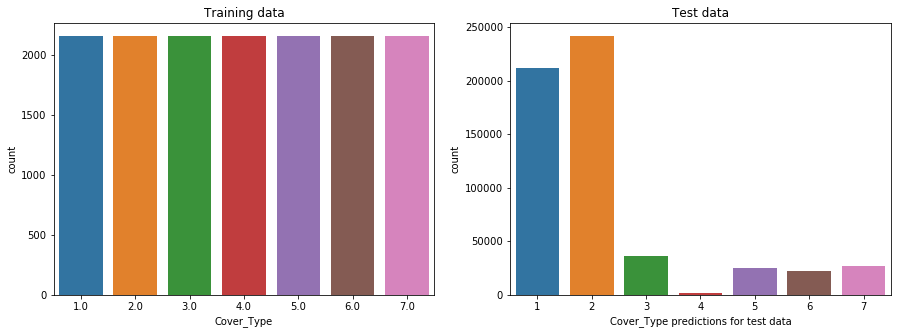

In [51]:
fig = plt.figure(figsize=(15, 5)) # (width,height);

plt.subplot(1,2,1)
plt.title('Training data')
sns.countplot(x="Cover_Type", hue=None, data=X_all);

plt.subplot(1,2,2)
plt.title('Test data')
sns.countplot(x=y_test_ext, hue=None);
plt.xlabel('Cover_Type predictions for test data');

The training data set consisted of a uniform distribution of known 'Cover_Type' classes. My predictions for the test data set are predominantly Cover_Type=1,2. Since the accuracy of my model is overall ok (~80% on the test set) these plots suggest the training set and test set contain substantially different observations of forest cover types. 


## 7.3 Accuracy of model classification <a id='section_7.3'></a>

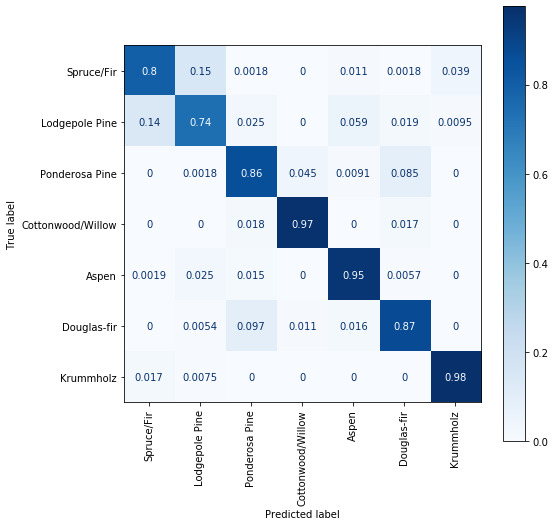

In [52]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix


fig = plt.figure(figsize=(8, 8)) # (width,height);

train, valid, y_train, y_valid = train_test_split(X_selected, y_clean, random_state=0)

classifier = ext_clf.fit(train, y_train)

ax = plt.subplot(1,1,1)
disp = plot_confusion_matrix(ext_clf, valid, y_valid,
                             display_labels=class_names,
                             cmap=plt.cm.Blues,
                             xticks_rotation='vertical',
                             normalize='true',
                             ax=ax)

On the training set, the cross-validated classification accuracy of my model is estimated to be ~88%. Examining the confusion matrix, this model has varying abilities to classify specific tree coverage types.

My model is best able to classify cottonwood/willow, aspen, and krummholz forest cover, with an accuracy score >95% for these classes. Ponderosa pine and douglas fir forest cover are classified with a ~87% accuracy, and are most likely to be misclassified as each other.

The most difficulty occurs in distinguishing spruce/firs and lodgepole pines. My model is able to correctly classify 75-79% of these forest cover types in the training set.

Considering the test data set appears to be predominantly spruce/firs and lodgepole pines, the best way to improve the classification accuracy of future modeling would be to investigate new features that provide a better separation of the properties of these forest cover types.


Final score: My model has a classification accuracy of 0.80522 on the test set, corresponding to a top 10% score on the Kaggle leaderboard.